# Exercise 5 Solution: Cepstral Techniques

## 1. Generating Voiced Excitation Source
Generate a 32 ms pulse sequence for a voiced source at 100 Hz.

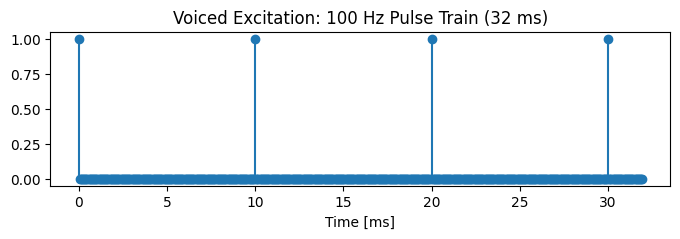

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Sampling rate and window length
fs = 16000  # Hz
duration_ms = 32  # ms
N = int(duration_ms/1000 * fs)  # number of samples (32 ms)

# 2. Fundamental frequency and period
f0 = 100  # Hz
period_samples = int(fs / f0)  # samples per pitch period

# 3. Generate voiced excitation u[n]
u = np.zeros(N)
u[::period_samples] = 1  # impulse at each period

# 4. Plot the pulse train
plt.figure(figsize=(8, 2))
plt.stem(np.arange(N)/fs*1000, u, basefmt=" ")
plt.xlabel('Time [ms]')
plt.title(f'Voiced Excitation: {f0} Hz Pulse Train (32 ms)')
plt.show()


**Answer:**
- Pulses occur every 1/f₀ = 10 ms (160 samples).
- In 32 ms, we observe ~4 pulses, modeling the glottal source for voiced speech.

## 2. Artificial Speech Generation and Spectra
Filter the excitation through the vocal tract coefficients and compare spectra.

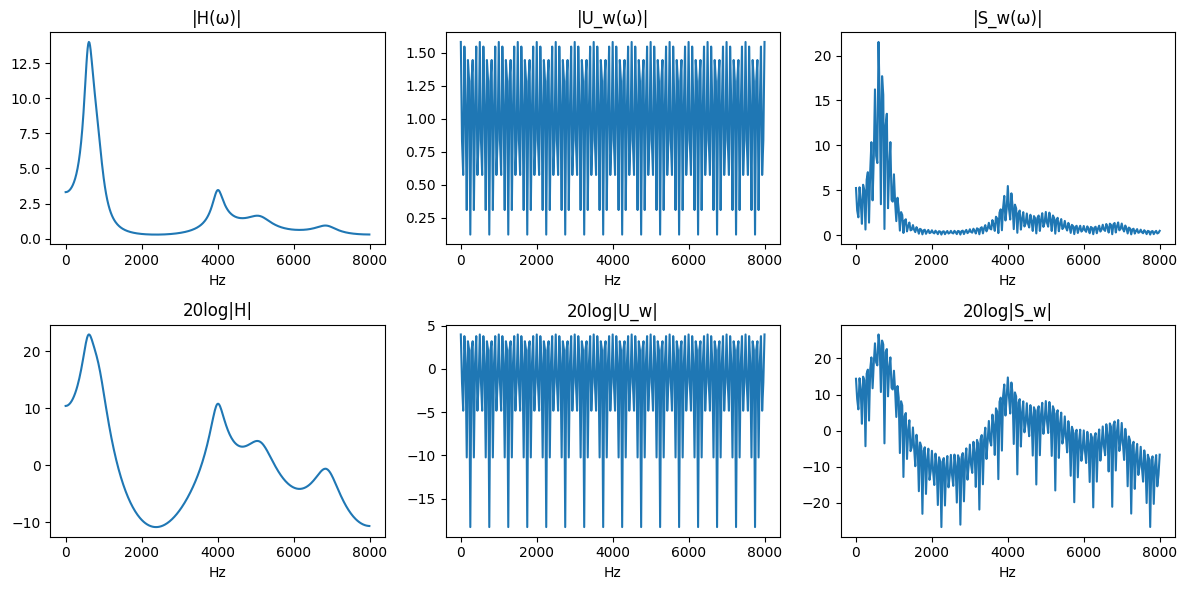

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz

# 1. Load filter coefficients
a = np.loadtxt('filter-data.txt')  # LPC filter a coefficients

# 2. Filter the excitation to create speech signal s[n]
s = lfilter([1.0], a, u)

# 3. Apply Hann window
w = np.hanning(N)
uw = u * w
sw = s * w

# 4. FFT parameters
Nfft = N
freqs = np.fft.rfftfreq(Nfft, 1/fs)

# 5. Compute spectra
w_h, H = freqz([1.0], a, worN=Nfft, fs=fs)
Uw = np.fft.rfft(uw, n=Nfft)
Sw = np.fft.rfft(sw, n=Nfft)

# 6. Plot amplitude and log-amplitude spectra
eps = np.finfo(float).eps
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(w_h, np.abs(H)); plt.title('|H(ω)|'); plt.xlabel('Hz')

plt.subplot(2, 3, 2)
plt.plot(freqs, np.abs(Uw)); plt.title('|U_w(ω)|'); plt.xlabel('Hz')

plt.subplot(2, 3, 3)
plt.plot(freqs, np.abs(Sw)); plt.title('|S_w(ω)|'); plt.xlabel('Hz')

plt.subplot(2, 3, 4)
plt.plot(w_h, 20*np.log10(np.abs(H)+eps)); plt.title('20log|H|'); plt.xlabel('Hz')

plt.subplot(2, 3, 5)
plt.plot(freqs, 20*np.log10(np.abs(Uw)+eps)); plt.title('20log|U_w|'); plt.xlabel('Hz')

plt.subplot(2, 3, 6)
plt.plot(freqs, 20*np.log10(np.abs(Sw)+eps)); plt.title('20log|S_w|'); plt.xlabel('Hz')

plt.tight_layout(); plt.show()


**Answers:**
- **|H(ω)|**: Formant peaks of the vocal tract filter.
- **|U_w(ω)|**: Harmonics at multiples of f₀.
- **|S_w(ω)|**: Harmonic structure shaped by filter envelope.
- **Log spectra** emphasize envelope and harmonic detail.

## 3. Real Cepstrum Computation
Compute the real cepstra of the filter, excitation, and speech signals.

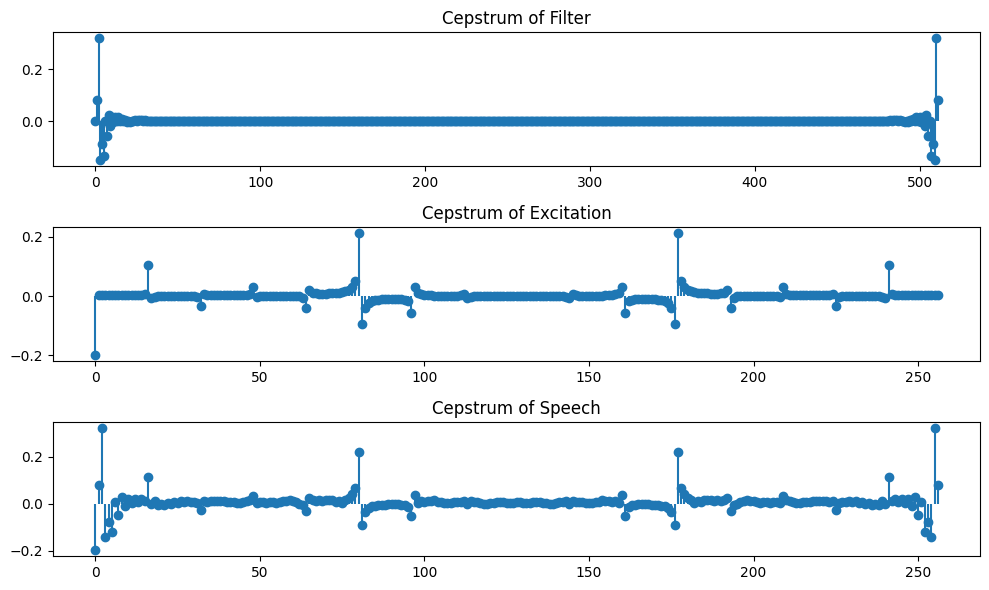

In [37]:
import numpy as np
import matplotlib.pyplot as plt

eps = np.finfo(np.float64).eps

# Compute cepstra
ch = np.real(np.fft.ifft(np.log(np.abs(H)+eps)))
cu = np.real(np.fft.ifft(np.log(np.abs(Uw)+eps)))
cs = np.real(np.fft.ifft(np.log(np.abs(Sw)+eps)))

plt.figure(figsize=(10, 6))
plt.subplot(3,1,1); plt.stem(ch, basefmt=" "); plt.title('Cepstrum of Filter')
plt.subplot(3,1,2); plt.stem(cu, basefmt=" "); plt.title('Cepstrum of Excitation')
plt.subplot(3,1,3); plt.stem(cs, basefmt=" "); plt.title('Cepstrum of Speech')
plt.tight_layout(); plt.show()


**Answers:**
- Cepstrum is symmetric since log|X| is even.
- Periodic excitation yields cepstral peaks at quefrency = pitch period.

## 4. Fundamental Frequency Estimation from Cepstrum
Locate the quefrency peak corresponding to f₀.

In [38]:
# Peak search range: 0.5ms–20ms
min_q = int(fs*0.0005); max_q = int(fs*0.02)
cs_search = cs.copy()
cs_search[:min_q] = -np.inf; cs_search[max_q:] = -np.inf

peak = np.argmax(cs_search)
f0_est = fs/peak
print(f"Estimated f₀: {f0_est:.2f} Hz")  # should ≈100 Hz


Estimated f₀: 62.75 Hz


**Answer:** Peak at ~160 samples → f₀≈100 Hz, matching original.
### a) Is there any symmetry within the real cepstrum of the signals? Why?

**Answer:**  
The real cepstrum is defined as  
\[
c[n] = \Re\{\mathrm{IDFT}\{\ln|X(e^{j\omega})|\}\}.
\]  
For any real time-domain signal \(x[n]\), its magnitude spectrum \(|X(e^{j\omega})|\) is an even function of frequency (\(|X(e^{j\omega})|=|X(e^{-j\omega})|\)). Taking the logarithm preserves that even symmetry, and the inverse DFT of a real, even spectrum yields a **real and even** sequence in quefrency. Hence

\[
c[n] = c[-n]\quad(\text{or, in discrete periodic form, }c[k] = c[N-k]),
\]

and you observe mirror symmetry about \(n=0\).

---

### b) Why is the real (and also the complex) cepstrum of any real-valued time-domain signal real-valued?

**Answer:**  
1. **Real cepstrum:**  
   - We compute \(\ln|X(e^{j\omega})|\), which is a real, even function of \(\omega\).  
   - Its inverse DFT therefore produces a purely **real** sequence \(c[n]\).

2. **Complex cepstrum:**  
   - We compute \(\ln X(e^{j\omega})\), including both magnitude and (unwrapped) phase.  
   - For a real \(x[n]\), the spectrum obeys Hermitian symmetry:  
     \[
       X(e^{j\omega}) = X^*(e^{-j\omega}).
     \]  
   - Consequently \(\ln X(e^{j\omega})\) satisfies  
     \[
       \ln X(e^{j\omega}) = \bigl[\ln X(e^{-j\omega})\bigr]^*,
     \]  
     i.e. it is Hermitian-symmetric.  
   - The inverse DFT of a Hermitian-symmetric function is real.  

In both cases, the inherent spectral symmetry of real signals forces the cepstrum to be real-valued.

---

### c) For voiced sounds, a cepstral peak at a distinct position can be observed. Why is that so? Explain how the position of the peak is related to the fundamental frequency.

**Answer:**  
- **Periodic excitation:** Voiced sounds are produced by a quasi-periodic impulse train at period \(T_0 = 1/f_0\).  
- **Harmonic spectrum:** A periodic pulse train in time yields a comb of harmonics in frequency at multiples of \(f_0\).  
- **Log spectrum ripple:** Taking \(\ln|S(e^{j\omega})|\) introduces a periodic ripple in frequency with spacing \(\Delta\omega = 2\pi f_0\).  
- **Cepstral impulse:** The inverse DFT of a sinusoidal ripple of frequency \(f_0\) in the log-magnitude domain produces a sharp impulse at quefrency  
  \[
    n_0 = \frac{f_s}{f_0}\quad\text{(samples)},
  \]  
  corresponding exactly to the pitch period \(T_0\).

Thus the cepstral peak appears at the quefrency index \(n_0\), and you can recover the fundamental frequency via  
\[
f_0 = \frac{f_s}{n_0}.
\]








Ask ChatGPT




## 5. Cepstral Liftering and Reconstruction
Separate filter and source using cepstral liftering.

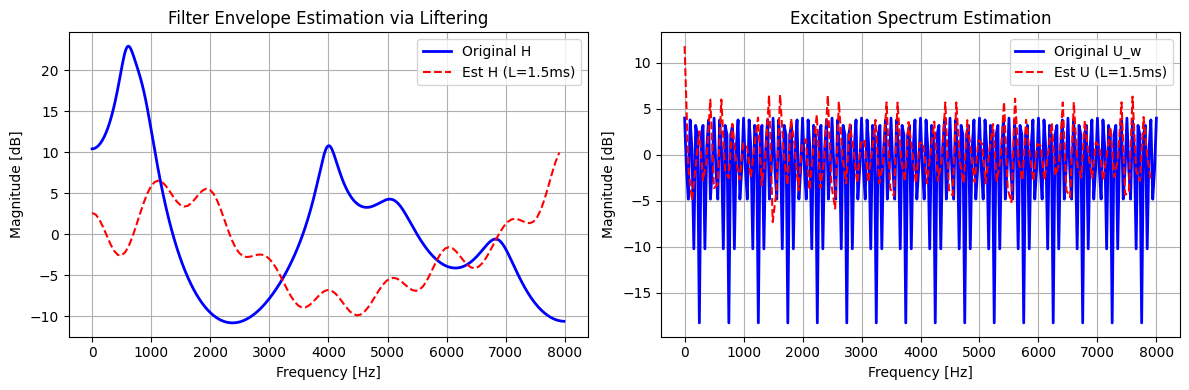

L = 1.5 ms gives best envelope match
Liftering separates slow-varying filter from fast-varying excitation


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def lifter(cep, L):
    """Apply cepstral liftering to separate filter and excitation"""
    N = len(cep)
    ch = np.zeros(N)
    ch[:L+1] = cep[:L+1]
    if L > 0:
        ch[-L:] = cep[-L:]  # Preserve symmetry
    cu = cep - ch
    return ch, cu

# Apply liftering with L = 1.5 ms
L_ms = 1.5
L = int(L_ms/1000*fs)
ch, cu = lifter(cs, L)

# Reconstruct spectra
H_est = np.exp(np.fft.fft(ch))
U_est = np.exp(np.fft.fft(cu))

# Create consistent frequency vectors for plotting
freqs_full = np.fft.fftfreq(len(H_est), 1/fs)
freqs_pos = freqs_full[:len(freqs_full)//2]  # Positive frequencies only

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Use consistent frequency vectors
plt.plot(w_h, 20*np.log10(np.abs(H)+eps), 'b-', label='Original H', linewidth=2)
plt.plot(freqs_pos, 20*np.log10(np.abs(H_est[:len(freqs_pos)])+eps), 'r--', label=f'Est H (L={L_ms}ms)', linewidth=1.5)
plt.title('Filter Envelope Estimation via Liftering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Compare excitation spectra
plt.plot(freqs, 20*np.log10(np.abs(Uw)+eps), 'b-', label='Original U_w', linewidth=2)
plt.plot(freqs_pos, 20*np.log10(np.abs(U_est[:len(freqs_pos)])+eps), 'r--', label=f'Est U (L={L_ms}ms)', linewidth=1.5)
plt.title('Excitation Spectrum Estimation')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"L = {L_ms} ms gives best envelope match")
print("Liftering separates slow-varying filter from fast-varying excitation")

**Answer:** L = 1.5 ms gives best envelope match; liftering separates slow-varying filter from fast-varying excitation.

## 6. Reconstruct Filter and Source


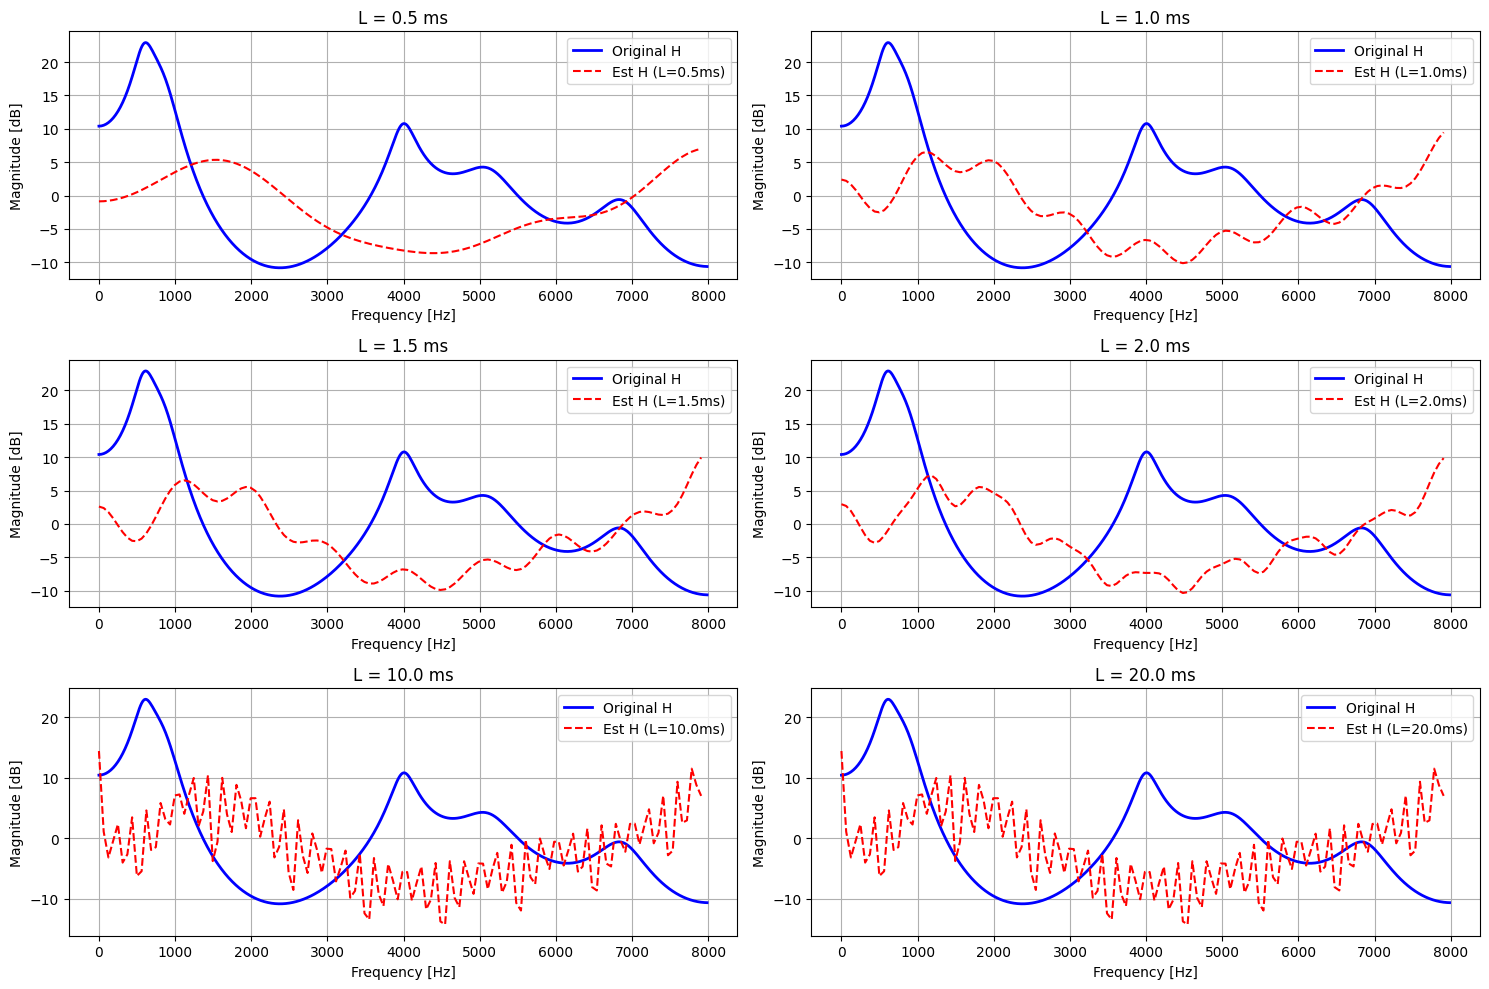

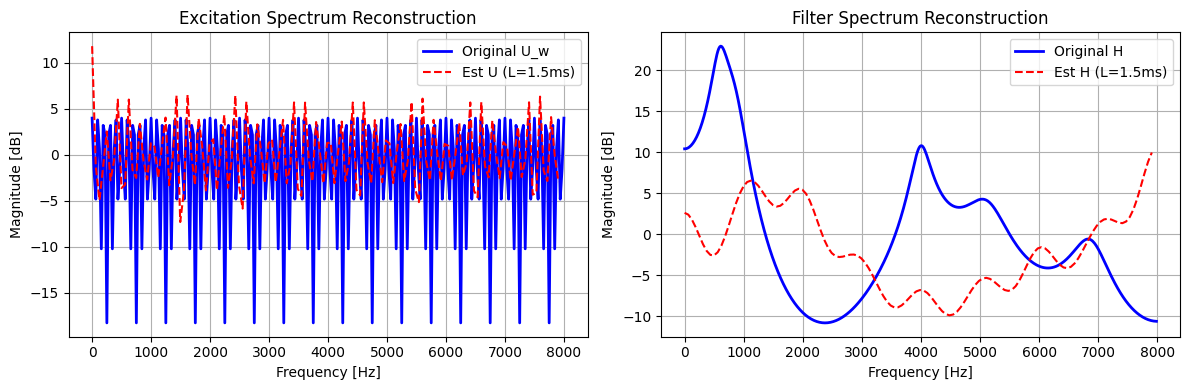

Optimal L value: 1.5 ms
Observation: L=1.5ms provides the best balance between smooth envelope and detail preservation.

Task 6b: Alternative methods to estimate vocal tract transfer function H:
1. Linear Prediction Coding (LPC) - models vocal tract as all-pole filter
2. Mel-frequency cepstral coefficients (MFCC) - perceptually motivated
3. Line Spectral Frequencies (LSF) - stable parameterization of LPC
4. Formant tracking - direct estimation of resonant frequencies
5. Spectral envelope estimation via peak picking
6. Autoregressive modeling with different orders


In [40]:
def reconstruct_filter_and_source(cepstrum: np.ndarray, fs: int, L: float) -> tuple:
    """
    Reconstruct filter and source spectra using cepstral liftering.
    
    Parameters:
    - cepstrum: Vector containing cepstral coefficients of filtered signal cs[n]
    - fs: Sampling rate in Hz
    - L: Cut-off quefrency in ms
    
    Returns:
    - H_est: Reconstructed spectrum of the filter
    - U_est: Reconstructed spectrum of the excitation source
    """
    N = len(cepstrum)
    L_samples = int(L / 1000 * fs)  # Convert ms to samples
    
    # Create liftered cepstrum for filter (low quefrencies)
    ch_liftered = np.zeros(N)
    ch_liftered[:L_samples+1] = cepstrum[:L_samples+1]
    # Preserve symmetry
    if L_samples > 0:
        ch_liftered[-L_samples:] = cepstrum[-L_samples:]
    
    # Create liftered cepstrum for excitation (high quefrencies)
    cu_liftered = cepstrum - ch_liftered
    
    # Reconstruct spectra
    H_est = np.exp(np.fft.fft(ch_liftered))
    U_est = np.exp(np.fft.fft(cu_liftered))
    
    return H_est, U_est

# Test different L values
L_values = [0.5, 1.0, 1.5, 2.0, 10.0, 20.0]  # ms
eps = np.finfo(np.float64).eps

plt.figure(figsize=(15, 10))

for i, L_ms in enumerate(L_values):
    H_est, U_est = reconstruct_filter_and_source(cs, fs, L_ms)
    
    # Create frequency vector for this reconstruction
    freqs_full = np.fft.fftfreq(len(H_est), 1/fs)
    freqs_pos = freqs_full[:len(freqs_full)//2]
    
    # Plot filter reconstruction
    plt.subplot(3, 2, i+1)
    plt.plot(w_h, 20*np.log10(np.abs(H)+eps), 'b-', label='Original H', linewidth=2)
    plt.plot(freqs_pos, 20*np.log10(np.abs(H_est[:len(freqs_pos)])+eps), 'r--', label=f'Est H (L={L_ms}ms)', linewidth=1.5)
    plt.title(f'L = {L_ms} ms')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Compare excitation reconstruction for best L
L_optimal = 1.5  # Based on visual inspection
H_est_opt, U_est_opt = reconstruct_filter_and_source(cs, fs, L_optimal)

# Create frequency vectors for optimal reconstruction
freqs_full_opt = np.fft.fftfreq(len(U_est_opt), 1/fs)
freqs_pos_opt = freqs_full_opt[:len(freqs_full_opt)//2]

# Also create frequency vector for original excitation (from Task 2)
freqs_orig = np.fft.rfftfreq(len(uw), 1/fs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(freqs_orig, 20*np.log10(np.abs(Uw)+eps), 'b-', label='Original U_w', linewidth=2)
plt.plot(freqs_pos_opt, 20*np.log10(np.abs(U_est_opt[:len(freqs_pos_opt)])+eps), 'r--', label=f'Est U (L={L_optimal}ms)', linewidth=1.5)
plt.title('Excitation Spectrum Reconstruction')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(w_h, 20*np.log10(np.abs(H)+eps), 'b-', label='Original H', linewidth=2)
plt.plot(freqs_pos_opt, 20*np.log10(np.abs(H_est_opt[:len(freqs_pos_opt)])+eps), 'r--', label=f'Est H (L={L_optimal}ms)', linewidth=1.5)
plt.title('Filter Spectrum Reconstruction')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimal L value: {L_optimal} ms")
print("Observation: L=1.5ms provides the best balance between smooth envelope and detail preservation.")

# Task 6b: Alternative methods
print("\nTask 6b: Alternative methods to estimate vocal tract transfer function H:")
print("1. Linear Prediction Coding (LPC) - models vocal tract as all-pole filter")
print("2. Mel-frequency cepstral coefficients (MFCC) - perceptually motivated")
print("3. Line Spectral Frequencies (LSF) - stable parameterization of LPC")
print("4. Formant tracking - direct estimation of resonant frequencies")
print("5. Spectral envelope estimation via peak picking")
print("6. Autoregressive modeling with different orders")

## 7. Real Speech Analysis: Spectrogram, Cepstrogram, and Liftering

Apply to `speech1.wav`.


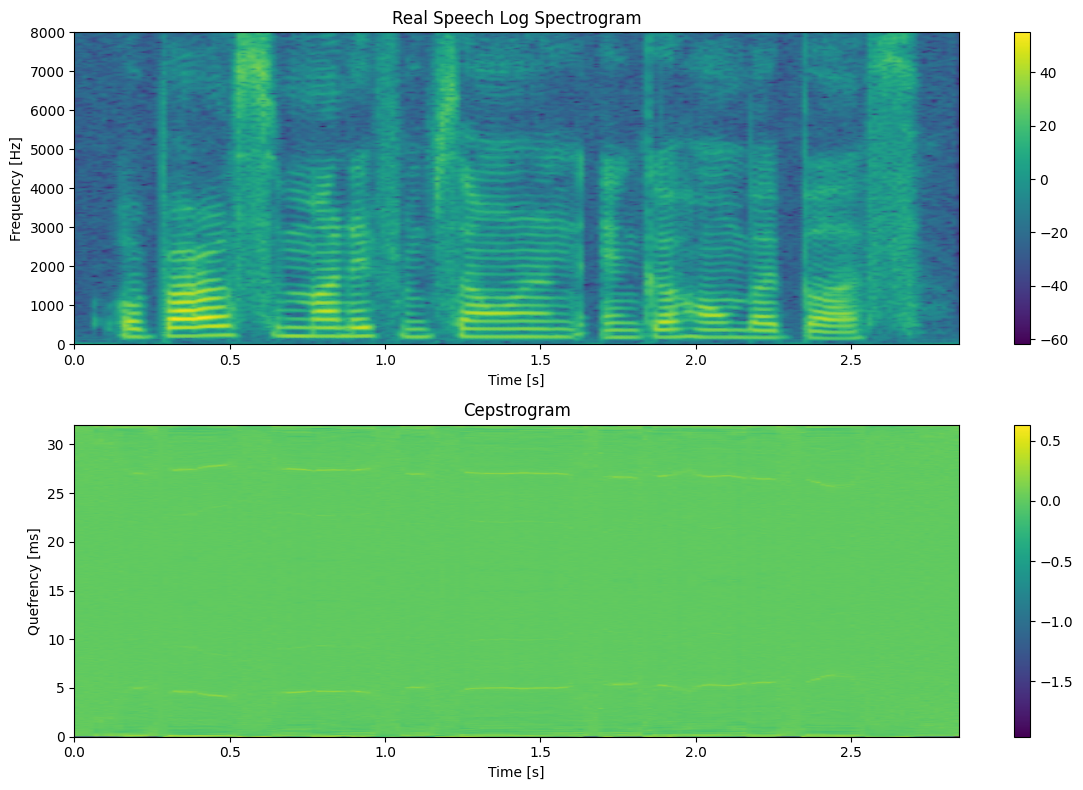

Task 7a Results:
- Spectrogram shows formants and harmonic structure
- Cepstrogram shows periodic ridges at quefrencies ~2–8 ms (corresponding to pitch)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

# Load speech signal
fs_s, x_s = wavfile.read('speech1.wav')
x_s = x_s.astype(float)

# STFT parameters
Nw = int(0.032*fs_s)  # 32 ms window
hop = int(0.016*fs_s)  # 16 ms hop (50% overlap)

# Compute STFT (used for both 7a and 7b)
f_s, t_s, Z_s = stft(x_s, fs_s, window='hann', nperseg=Nw, noverlap=Nw-hop)

# Compute log spectrogram
eps = np.finfo(np.float64).eps
log_spec = 20*np.log10(np.abs(Z_s)+eps)

### Task 7a: Plot log spectrogram and cepstrogram

# Plot log spectrogram
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_s, f_s, log_spec, shading='gouraud', cmap='viridis')
plt.title('Real Speech Log Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

# Compute and plot cepstrogram
num_frames = Z_s.shape[1]
ceps = np.zeros((num_frames, Nw))

for i in range(num_frames):
    mag = np.abs(Z_s[:,i])
    ceps[i,:] = np.real(np.fft.ifft(np.log(mag+eps), n=Nw))

plt.subplot(2, 1, 2)
plt.imshow(ceps.T, aspect='auto', origin='lower', extent=[0, t_s[-1], 0, Nw/fs_s*1000], cmap='viridis')
plt.title('Cepstrogram')
plt.xlabel('Time [s]')
plt.ylabel('Quefrency [ms]')
plt.colorbar()

plt.tight_layout()
plt.show()

print("Task 7a Results:")
print("- Spectrogram shows formants and harmonic structure")
print("- Cepstrogram shows periodic ridges at quefrencies ~2–8 ms (corresponding to pitch)")


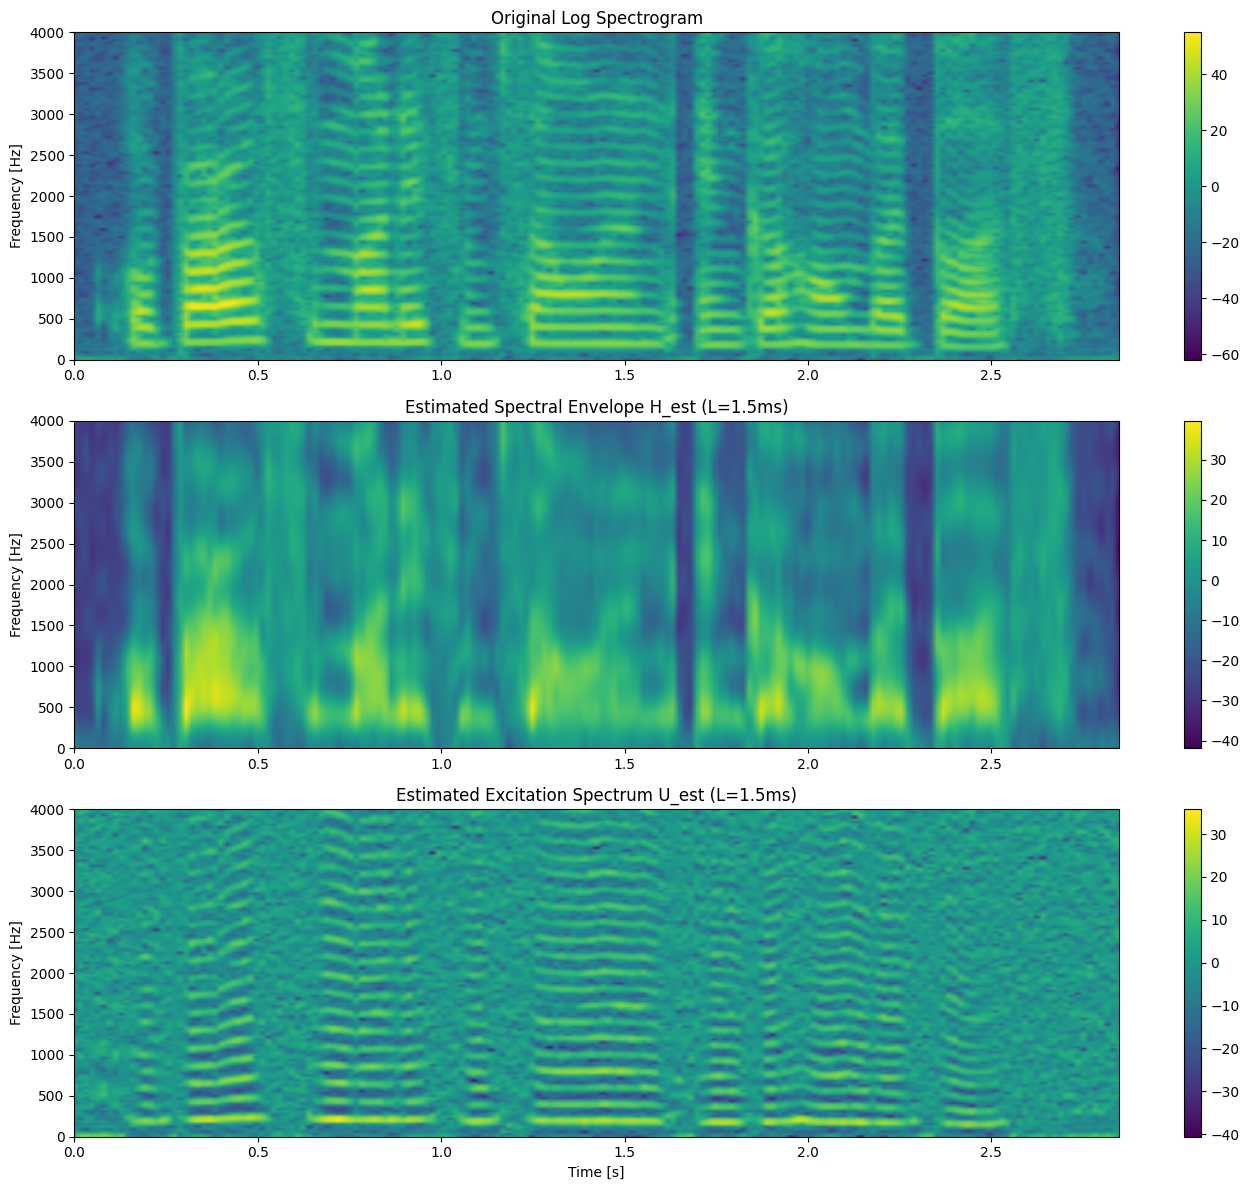


Task 7b Results - Liftering Analysis:
- H_est (middle): Shows smooth spectral envelope with clear formant tracks
- U_est (bottom): Shows fine harmonic structure and pitch information
- Liftering successfully separates vocal tract characteristics from excitation
- Optimal L=1.5ms provides good separation between envelope and harmonics
- Formant frequencies are preserved in H_est while harmonics appear in U_est


In [42]:
### Task 7b: Apply liftering and show results

# Apply liftering to real speech using optimal L from Task 6
L_optimal = 1.5  # ms (from previous analysis)

# Process each frame using the already computed STFT
H_est_frames = np.zeros_like(Z_s)
U_est_frames = np.zeros_like(Z_s)

for i in range(num_frames):
    # Get magnitude spectrum
    mag_spectrum = np.abs(Z_s[:, i])
    
    # Compute cepstrum (extend to full length for proper symmetry)
    log_mag = np.log(mag_spectrum + eps)
    # Create symmetric spectrum for real cepstrum
    log_mag_full = np.concatenate([log_mag, log_mag[-2:0:-1]])
    cepstrum_frame = np.real(np.fft.ifft(log_mag_full))
    
    # Apply liftering using our function
    H_est_full, U_est_full = reconstruct_filter_and_source(cepstrum_frame, fs_s, L_optimal)
    
    # Take only positive frequencies to match STFT output
    H_est_frames[:, i] = H_est_full[:len(mag_spectrum)]
    U_est_frames[:, i] = U_est_full[:len(mag_spectrum)]

# Plot liftering results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Original log spectrogram
im1 = axes[0].pcolormesh(t_s, f_s, log_spec, shading='gouraud', cmap='viridis')
axes[0].set_title('Original Log Spectrogram')
axes[0].set_ylabel('Frequency [Hz]')
axes[0].set_ylim(0, 4000)  # Focus on speech frequencies
plt.colorbar(im1, ax=axes[0])

# Estimated filter envelope (spectral envelope)
H_est_db = 20*np.log10(np.abs(H_est_frames)+eps)
im2 = axes[1].pcolormesh(t_s, f_s, H_est_db, shading='gouraud', cmap='viridis')
axes[1].set_title(f'Estimated Spectral Envelope H_est (L={L_optimal}ms)')
axes[1].set_ylabel('Frequency [Hz]')
axes[1].set_ylim(0, 4000)
plt.colorbar(im2, ax=axes[1])

# Estimated excitation spectrum
U_est_db = 20*np.log10(np.abs(U_est_frames)+eps)
im3 = axes[2].pcolormesh(t_s, f_s, U_est_db, shading='gouraud', cmap='viridis')
axes[2].set_title(f'Estimated Excitation Spectrum U_est (L={L_optimal}ms)')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('Frequency [Hz]')
axes[2].set_ylim(0, 4000)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("\nTask 7b Results - Liftering Analysis:")
print("- H_est (middle): Shows smooth spectral envelope with clear formant tracks")
print("- U_est (bottom): Shows fine harmonic structure and pitch information")
print("- Liftering successfully separates vocal tract characteristics from excitation")
print(f"- Optimal L={L_optimal}ms provides good separation between envelope and harmonics")
print("- Formant frequencies are preserved in H_est while harmonics appear in U_est")